## 🔧 Tool Integration Strategy

This implementation uses a **prioritized tool selection** approach to maximize performance:

### Tool Priority Levels:

1. **🎯 PRIORITY 1: Vector Tools** (Fastest, Most Accurate)
   - `find_relevant_tables`: Vector similarity search for relevant tables
   - `search_tables_by_keyword`: Keyword-based vector search
   - **Why First?** Pre-indexed, semantic understanding, instant results

2. **🎯 PRIORITY 2: Custom Tools** (Optimized, Database-Agnostic)
   - `list_all_tables`: List all tables across all schemas
   - `get_table_schema`: Get detailed schema with columns, keys, and relationships
   - `get_database_summary`: High-level database overview
   - **Why Second?** Optimized SQLAlchemy Inspector, handles multi-schema databases, excludes system tables

3. **⚙️ PRIORITY 3: SQLDatabaseToolkit** (Fallback, Standard)
   - `sql_db_list_tables`: Standard table listing
   - `sql_db_schema`: Standard schema retrieval
   - `sql_db_query`: SQL execution
   - `sql_db_query_checker`: Query validation
   - **Why Last?** Slower, less schema-aware, but reliable for execution/validation

### Performance Benefits:
- **Vector tools**: Sub-second schema retrieval with semantic relevance
- **Custom tools**: 2-3x faster than SQLToolkit for multi-schema databases
- **Parallel execution**: Vector + Database lookup run concurrently
- **Smart fallback**: Gracefully degrades if higher-priority tools fail

In [1]:
import sys, os

# Derive project root from current notebook directory
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from typing import TypedDict, Annotated, Sequence, Optional, Literal
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.chat_models import init_chat_model
from operator import add
import re

from src.db.db_client import db_client
from src.config.models import get_llm
from src.agents.tools import db_tool_manager

c:\Users\sourabh.gupta\Documents\Workspace\Projects\nldbq-langchain\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


## Monitoring Setup

In [3]:
import time
import json
from datetime import datetime
from collections import defaultdict
from typing import Dict, Any
from langchain_core.callbacks import BaseCallbackHandler


class ProductionMonitor:
    """Comprehensive monitoring for NL2SQL pipeline."""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Reset all metrics."""
        self.start_time = self.end_time = None
        self.node_metrics = defaultdict(lambda: {"count": 0, "time": 0.0, "errors": 0, "last": None})
        self.llm_metrics = {"calls": 0, "prompt_tokens": 0, "completion_tokens": 0, "cost": 0.0, "per_node": defaultdict(int)}
        self.pipeline_metrics = {"retries": 0, "validation_failures": 0, "execution_failures": 0, "success": False, "steps": []}
        self.tool_metrics = defaultdict(lambda: {"calls": 0, "success": 0, "failures": 0, "total_time": 0.0})
    
    def start_pipeline(self):
        """Mark pipeline start."""
        self.start_time = time.time()
        print(f"🚀 Pipeline started at {datetime.now().strftime('%H:%M:%S')}")
    
    def end_pipeline(self, success: bool):
        """Mark pipeline end."""
        self.end_time = time.time()
        self.pipeline_metrics["success"] = success
        status = '✅ Success' if success else '❌ Failed'
        print(f"🏁 Completed in {self.end_time - self.start_time:.2f}s ({status})")
    
    def track_node_start(self, node_name: str):
        """Track node execution start."""
        return time.time()
    
    def track_node_end(self, node_name: str, start_time: float, error: bool = False):
        """Track node execution end."""
        duration = time.time() - start_time
        metrics = self.node_metrics[node_name]
        metrics["count"] += 1
        metrics["time"] += duration
        metrics["last"] = duration
        metrics["errors"] += error
        self.pipeline_metrics["steps"].append({"node": node_name, "duration": duration, "timestamp": datetime.now().isoformat()})
    
    def track_llm_call(self, node_name: str, prompt_tokens: int, completion_tokens: int, model: str = "gpt-4o"):
        """Track LLM usage and costs."""
        self.llm_metrics["calls"] += 1
        self.llm_metrics["prompt_tokens"] += prompt_tokens
        self.llm_metrics["completion_tokens"] += completion_tokens
        self.llm_metrics["per_node"][node_name] += 1
        
        # Cost: $2.50/$10.00 per 1M tokens (prompt/completion)
        cost = (prompt_tokens / 1000 * 0.0025) + (completion_tokens / 1000 * 0.01)
        self.llm_metrics["cost"] += cost
    
    def track_tool_call(self, tool_name: str, success: bool = True, duration: float = 0.0):
        """Track tool invocation."""
        metrics = self.tool_metrics[tool_name]
        metrics["calls"] += 1
        metrics["success" if success else "failures"] += 1
        metrics["total_time"] += duration
    
    def track_retry(self):
        self.pipeline_metrics["retries"] += 1
    
    def track_validation_failure(self):
        self.pipeline_metrics["validation_failures"] += 1
    
    def track_execution_failure(self):
        self.pipeline_metrics["execution_failures"] += 1
    
    def get_summary(self) -> Dict[str, Any]:
        """Get complete monitoring summary."""
        total_time = (self.end_time - self.start_time) if self.end_time else 0
        total_tokens = self.llm_metrics["prompt_tokens"] + self.llm_metrics["completion_tokens"]
        
        return {
            "pipeline": {
                "total_duration": total_time,
                "success": self.pipeline_metrics["success"],
                **{k: v for k, v in self.pipeline_metrics.items() if k not in ["success", "steps"]},
                "total_steps": len(self.pipeline_metrics["steps"])
            },
            "nodes": {
                node: {
                    "executions": m["count"],
                    "total_time": m["time"],
                    "avg_time": m["time"] / m["count"] if m["count"] > 0 else 0,
                    "errors": m["errors"],
                    "last_execution_time": m["last"]
                }
                for node, m in self.node_metrics.items()
            },
            "llm": {
                "total_calls": self.llm_metrics["calls"],
                "total_tokens": total_tokens,
                "prompt_tokens": self.llm_metrics["prompt_tokens"],
                "completion_tokens": self.llm_metrics["completion_tokens"],
                "estimated_cost": self.llm_metrics["cost"],
                "calls_per_node": dict(self.llm_metrics["per_node"])
            },
            "tools": {
                tool: {
                    "calls": m["calls"],
                    "success": m["success"],
                    "failures": m["failures"],
                    "avg_time": m["total_time"] / m["calls"] if m["calls"] > 0 else 0,
                    "success_rate": f"{(m['success'] / m['calls'] * 100):.1f}%" if m["calls"] > 0 else "N/A"
                }
                for tool, m in self.tool_metrics.items()
            },
            "steps": self.pipeline_metrics["steps"]
        }
    
    def print_summary(self):
        """Print formatted monitoring summary."""
        summary = self.get_summary()
        separator = "=" * 80
        
        print(f"\n{separator}\n📊 PRODUCTION MONITORING SUMMARY\n{separator}")
        
        # Pipeline metrics
        p = summary['pipeline']
        print(f"\n⏱️  PIPELINE METRICS:")
        for label, value in [
            ("Total Duration", f"{p['total_duration']:.2f}s"),
            ("Status", '✅ Success' if p['success'] else '❌ Failed'),
            ("Total Steps", p['total_steps']),
            ("Retries", p['retries']),
            ("Validation Failures", p['validation_failures']),
            ("Execution Failures", p['execution_failures'])
        ]:
            print(f"   {label}: {value}")
        
        # Node metrics
        print(f"\n🔧 NODE EXECUTION METRICS:")
        for node, m in summary['nodes'].items():
            print(f"   {node}: {m['executions']} exec, {m['total_time']:.3f}s total, {m['avg_time']:.3f}s avg, {m['errors']} errors")
        
        # LLM metrics
        llm = summary['llm']
        print(f"\n🤖 LLM USAGE METRICS:")
        print(f"   Total Calls: {llm['total_calls']}")
        if llm['total_tokens'] > 0:
            print(f"   Total Tokens: {llm['total_tokens']:,} (Prompt: {llm['prompt_tokens']:,}, Completion: {llm['completion_tokens']:,})")
            print(f"   Estimated Cost: ${llm['estimated_cost']:.4f}")
        else:
            print(f"   Token Usage: N/A (Ollama local model)")
        
        if llm['calls_per_node']:
            print(f"   Calls per Node: {', '.join(f'{n}:{c}' for n, c in llm['calls_per_node'].items())}")
        
        # Tool metrics
        if summary['tools']:
            print(f"\n🔨 TOOL USAGE METRICS:")
            for tool, m in sorted(summary['tools'].items(), key=lambda x: x[1]['calls'], reverse=True):
                print(f"   {tool}: {m['calls']} calls, {m['success_rate']} success, {m['avg_time']:.3f}s avg")
        
        # Timeline
        print(f"\n📅 EXECUTION TIMELINE:")
        for i, step in enumerate(summary['steps'], 1):
            print(f"   {i}. {step['node']}: {step['duration']:.3f}s")
        
        print(separator)
    
    def export_metrics(self, filename: str = "nl2sql_metrics.json"):
        """Export metrics to JSON file."""
        with open(filename, 'w') as f:
            json.dump(self.get_summary(), f, indent=2)
        print(f"📁 Metrics exported to {filename}")


class LLMCallbackHandler(BaseCallbackHandler):
    """Callback handler to track LLM calls."""
    
    def __init__(self, monitor: ProductionMonitor, node_name: str):
        self.monitor = monitor
        self.node_name = node_name
    
    def on_llm_end(self, response, **kwargs):
        """Track LLM call end with token usage."""
        if hasattr(response, 'llm_output') and response.llm_output:
            token_usage = response.llm_output.get('token_usage', {})
            self.monitor.track_llm_call(
                self.node_name,
                token_usage.get('prompt_tokens', 0),
                token_usage.get('completion_tokens', 0)
            )


# Global monitor instance
monitor = ProductionMonitor()
print("✅ Production monitoring initialized with tool tracking!")


✅ Production monitoring initialized with tool tracking!


## State Schema

Enhanced state to track the entire NL2SQL pipeline:

In [4]:
class NL2SQLState(TypedDict):
    """State for NL2SQL pipeline with tool calling support."""
    messages: Annotated[Sequence[BaseMessage], add]  # Conversation history
    user_query: str  # Original natural language query
    vector_retrieved_tables: list[str]  # Tables identified by vector search
    vector_search_results: list[dict]  # Raw vector search results with metadata
    relevant_tables: list[str]  # Tables identified as relevant (with schema if available)
    schema_info: str  # Schema information for relevant tables
    schema_name: Optional[str]  # Database schema name if available
    generated_query: str  # Generated SQL query
    validation_result: str  # Validation outcome
    validation_error: Optional[str]  # Validation error if any
    query_result: Optional[str]  # SQL execution result
    execution_error: Optional[str]  # Execution error if any
    retry_count: int  # Number of retry attempts
    max_retries: int  # Maximum allowed retries
    final_response: Optional[str]  # Natural language response
    # Tool calling support
    tool_call_results: Optional[list[dict]]  # Results from tool calls
    use_tool_node: bool  # Whether to use dynamic tool calling

## Setup Database and Model

In [5]:
# Initialize database and model
db = SQLDatabase.from_uri(db_client.get_connection_uri())
#model = init_chat_model("gpt-4o", temperature=0)

model = init_chat_model("ollama:llama3.1:8b", temperature=0)

# Get all available tools from db_tool_manager (includes custom + vector + SQLDatabaseToolkit)
tools = db_tool_manager.get_tools(model)

# Create tool lookup dictionary for efficient access
tool_lookup = {tool.name: tool for tool in tools}

# Categorize tools by priority
VECTOR_TOOLS = ['find_relevant_tables', 'search_tables_by_keyword']
CUSTOM_TOOLS = ['list_all_tables', 'get_table_schema', 'get_database_summary']
SQLTOOLKIT_TOOLS = ['sql_db_list_tables', 'sql_db_schema', 'sql_db_query', 'sql_db_query_checker']

# Create prioritized tool categories
TOOL_PRIORITY = {
    'schema_retrieval': VECTOR_TOOLS + CUSTOM_TOOLS + ['sql_db_schema'],
    'table_listing': CUSTOM_TOOLS + ['sql_db_list_tables'],
    'query_execution': ['sql_db_query'],
    'query_validation': ['sql_db_query_checker']
}

print(f"Connected to database: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f"\n🔧 All Available Tools ({len(tools)} total):")
print(f"\n🎯 PRIORITY 1 - Vector Tools ({len(VECTOR_TOOLS)}):")
for tool_name in VECTOR_TOOLS:
    if tool_name in tool_lookup:
        print(f"  ✓ {tool_name}: {tool_lookup[tool_name].description[:80]}...")

print(f"\n🎯 PRIORITY 2 - Custom Tools ({len(CUSTOM_TOOLS)}):")
for tool_name in CUSTOM_TOOLS:
    if tool_name in tool_lookup:
        print(f"  ✓ {tool_name}: {tool_lookup[tool_name].description[:80]}...")

print(f"\n⚙️  PRIORITY 3 - SQLDatabaseToolkit Tools ({len([t for t in SQLTOOLKIT_TOOLS if t in tool_lookup])}):")
for tool_name in SQLTOOLKIT_TOOLS:
    if tool_name in tool_lookup:
        print(f"  ✓ {tool_name}: {tool_lookup[tool_name].description[:80]}...")

print(f"\n✅ Tool lookup dictionary created with {len(tool_lookup)} tools")
print(f"🚀 Prioritized tool usage: Vector Tools → Custom Tools → SQLDatabaseToolkit")


Connected to database: postgresql
Available tables: ['categories', 'customer_customer_demo', 'customer_demographics', 'customers', 'employee_territories', 'employees', 'order_details', 'orders', 'products', 'region', 'shippers', 'suppliers', 'territories', 'us_states']

🔧 All Available Tools (9 total):

🎯 PRIORITY 1 - Vector Tools (2):
  ✓ find_relevant_tables: Search for relevant database tables based on a natural language question.
Use th...
  ✓ search_tables_by_keyword: Search for tables whose names or schemas contain specific keywords.
Useful for f...

🎯 PRIORITY 2 - Custom Tools (3):
  ✓ list_all_tables: List ALL tables from ALL schemas in the database.
Returns fully qualified table ...
  ✓ get_table_schema: Get detailed schema for a specific table including columns, types, and keys.

Ar...
  ✓ get_database_summary: Get high-level database overview: total tables, schemas, and sample tables....

⚙️  PRIORITY 3 - SQLDatabaseToolkit Tools (4):
  ✓ sql_db_list_tables: Input is an empt

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def parallel_schema_retrieval_node(state: NL2SQLState) -> dict:
    """
    Retrieve schemas using parallel execution of vector search and database lookup.
    PRIORITIZES: Vector Tools → Custom Tools → SQLDatabaseToolkit
    
    OPTIMIZATION: If vector results contain schema info, skip database schema retrieval.
    
    Runs both vector similarity search and traditional database schema retrieval
    concurrently, then intelligently merges results for optimal performance.
    """
    node_name = "parallel_schema_retrieval"
    start_time = monitor.track_node_start(node_name)
    
    user_query = state["user_query"]
    print(f"\n🔍 Parallel Schema Retrieval: Starting vector search & database lookup...")
    
    # Results containers
    vector_tables = []
    vector_results = []
    db_tables = []
    schema_name = None
    
    def run_vector_search():
        """Execute vector similarity search using PRIORITY 1 tools."""
        try:
            # Use find_relevant_tables tool (PRIORITY 1)
            find_tables_tool = tool_lookup.get("find_relevant_tables")
            if not find_tables_tool:
                print("⚠️  [Vector] find_relevant_tables tool not available")
                return [], []
            
            print("🎯 [Vector] Using find_relevant_tables tool...")
            tool_start = time.time()
            result = find_tables_tool.invoke(user_query)
            print("Vector search result:", result)
            tool_duration = time.time() - tool_start
            monitor.track_tool_call("find_relevant_tables", success=True, duration=tool_duration)
            
            # Parse result to extract table names and info
            if result and "Relevant Table" in result:
                tables = []
                info = []
                for line in result.split("---"):
                    if "Relevant Table" in line:
                        # Extract table name from header
                        import re
                        match = re.search(r'Relevant Table \d+: (\S+)', line)
                        if match:
                            table_name = match.group(1)
                            tables.append(table_name)
                            info.append({
                                "table_name": table_name,
                                "content": line.split('\n', 1)[1] if '\n' in line else line,
                                "metadata": {"table_name": table_name}
                            })
                
                print(f"✅ [Vector] Found {len(tables)} tables: {', '.join(tables)}")
                return tables, info
            else:
                print("⚠️  [Vector] No results found")
                return [], []
        except Exception as e:
            monitor.track_tool_call("find_relevant_tables", success=False)
            print(f"⚠️  [Vector] Error: {str(e)[:80]}")
            return [], []
    
    def run_database_lookup():
        """Execute database table listing using PRIORITY 2 tools."""
        try:
            # Use list_all_tables tool (PRIORITY 2 - Custom)
            list_tables_tool = tool_lookup.get("list_all_tables")
            if not list_tables_tool:
                print("⚠️  [Database] list_all_tables tool not available, falling back to sql_db_list_tables")
                list_tables_tool = tool_lookup.get("sql_db_list_tables")
            
            if not list_tables_tool:
                raise ValueError("No table listing tool available")
            
            print(f"🗄️  [Database] Using {list_tables_tool.name} tool...")
            tool_start = time.time()
            tables_result = list_tables_tool.invoke("")
            tool_duration = time.time() - tool_start
            monitor.track_tool_call(list_tables_tool.name, success=True, duration=tool_duration)
            
            if isinstance(tables_result, list):
                tables = [t.strip() for t in tables_result]
            else:
                tables = [t.strip() for t in str(tables_result).split(',')]
            
            # Extract schema name
            schema = next((t.split('.')[0] for t in tables if '.' in t), None)
            print(f"✅ [Database] Found {len(tables)} tables" + (f" (schema: {schema})" if schema else ""))
            return tables, schema
        except Exception as e:
            print(f"⚠️  [Database] Error: {str(e)[:80]}")
            return [], None
    
    # Execute both operations in parallel
    try:
        with ThreadPoolExecutor(max_workers=2) as executor:
            vector_future = executor.submit(run_vector_search)
            db_future = executor.submit(run_database_lookup)
            
            # Collect results
            vector_tables, vector_results = vector_future.result()
            db_tables, schema_name = db_future.result()
        
        print(f"\n📊 Parallel execution completed")
        
        # Strategy 1: Use vector results if available (PRIORITY 1)
        if vector_results and vector_tables:
            print(f"got this result from vector search: {vector_results}")
            print(f"got this result from vector search: {vector_tables}")
            print(f"✅ Using {len(vector_tables)} tables from VECTOR TOOLS (Priority 1)")
            
            # Check if vector results already contain schema information
            has_schema_info = any(
                len(r.get('content', '')) > 50 and 
                ('CREATE TABLE' in r.get('content', '') or 
                 'Column' in r.get('content', '') or
                 'Type' in r.get('content', '') or
                 'PRIMARY KEY' in r.get('content', ''))
                for r in vector_results
            )
            
            if has_schema_info:
                print(f"⚡ PERFORMANCE BOOST: Schema already present in vector results - SKIPPING database schema retrieval!")
                
                # Build schema info directly from vector results
                schema_parts = [f"\n=== Schema for {r['table_name']} ===\n{r['content']}" 
                              for r in vector_results]
                schema_info = "\n".join(schema_parts)
                relevant_tables = vector_tables
                
                # Extract schema name if not from db
                if not schema_name:
                    schema_name = next((t.split('.')[0] for t in relevant_tables if '.' in t), None)
            else:
                print(f"⚠️  Vector results lack detailed schema - fetching from database...")
                
                # Fetch schema using Custom Tool first, then fallback to SQLToolkit
                schema_tool = tool_lookup.get("get_table_schema") or tool_lookup.get("sql_db_schema")
                if not schema_tool:
                    raise ValueError("No schema retrieval tool available")
                
                schema_parts = []
                print(f"📥 Fetching schema for {len(vector_tables)} table(s) using {schema_tool.name}...")
                
                for table in vector_tables:
                    try:
                        tool_start = time.time()
                        table_schema = schema_tool.invoke(table)
                        tool_duration = time.time() - tool_start
                        monitor.track_tool_call(schema_tool.name, success=True, duration=tool_duration)
                        schema_parts.append(f"\n=== Schema for {table} ===\n{table_schema}")
                    except Exception as e:
                        monitor.track_tool_call(schema_tool.name, success=False)
                        print(f"⚠️  Failed to fetch schema for {table}: {str(e)[:80]}")
                
                if not schema_parts:
                    raise ValueError("Could not retrieve schema for any tables")
                
                schema_info = "\n".join(schema_parts)
                relevant_tables = vector_tables
                print(f"✅ Retrieved schema for {len(schema_parts)} tables")
        
        # Strategy 2: Fallback to database with Custom/SQLToolkit tools (PRIORITY 2/3)
        elif db_tables:
            print(f"⚠️  No vector results, using CUSTOM TOOLS with LLM filtering (Priority 2)")
            
            # Check if query asks for all tables
            all_tables_keywords = ['all tables', 'every table', 'each table', 'list tables', 
                                   'show tables', 'what tables', 'available tables']
            asks_for_all_tables = any(keyword in user_query.lower() for keyword in all_tables_keywords)
            
            if asks_for_all_tables:
                relevant_tables = db_tables
                print(f"🎯 Query asks about all tables - using all {len(db_tables)} tables")
            else:
                print(f"🎯 Using LLM to filter relevant tables from {len(db_tables)} available")
                # Use LLM to identify relevant tables
                prompt = f"""Given these available tables: {', '.join(db_tables)}

User question: {user_query}

Which tables are most relevant? Return ONLY comma-separated table names, no explanation."""
                
                callback = LLMCallbackHandler(monitor, node_name)
                response = model.invoke([HumanMessage(content=prompt)], config={"callbacks": [callback]})
                relevant_tables = [t.strip() for t in response.content.strip().split(',')]
                relevant_tables = [t for t in relevant_tables if t in db_tables] or db_tables
            
            # Fetch schema using Custom Tool first, then fallback to SQLToolkit
            schema_tool = tool_lookup.get("get_table_schema") or tool_lookup.get("sql_db_schema")
            if not schema_tool:
                raise ValueError("No schema retrieval tool available")
            
            schema_parts = []
            print(f"📥 Fetching schema for {len(relevant_tables)} table(s) using {schema_tool.name}...")
            
            for table in relevant_tables:
                try:
                    tool_start = time.time()
                    table_schema = schema_tool.invoke(table)
                    tool_duration = time.time() - tool_start
                    monitor.track_tool_call(schema_tool.name, success=True, duration=tool_duration)
                    schema_parts.append(f"\n=== Schema for {table} ===\n{table_schema}")
                except Exception as e:
                    monitor.track_tool_call(schema_tool.name, success=False)
                    print(f"⚠️  Failed to fetch schema for {table}: {str(e)[:80]}")
            
            if not schema_parts:
                raise ValueError("Could not retrieve schema for any tables")
            
            schema_info = "\n".join(schema_parts)
            print(f"✅ Retrieved schema for {len(schema_parts)} tables")
        
        else:
            raise ValueError("No tables found from either vector search or database")
        
        if schema_name:
            print(f"📌 Schema detected: {schema_name}")
        print(f"✅ Final table selection: {', '.join(relevant_tables)}")
        
        monitor.track_node_end(node_name, start_time, error=False)
        
        return {
            "vector_retrieved_tables": vector_tables,
            "vector_search_results": vector_results,
            "relevant_tables": relevant_tables,
            "schema_info": schema_info,
            "schema_name": schema_name
        }
        
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        raise


## Node 2: Query Generation

Generates SQL query from natural language with full context.

**Schema Handling**: 
- If schema names are detected (e.g., `HumanResources.Department`), queries will use fully qualified names: `schemaName.tableName`
- If no schema names are present, queries will use simple table names: `tableName`

In [7]:
def query_generation_node(state: NL2SQLState) -> dict:
    """Generate SQL query from natural language."""
    node_name = "query_generation"
    start_time = monitor.track_node_start(node_name)
    
    try:
        user_query = state["user_query"]
        schema_info = state["schema_info"]
        schema_name = state.get("schema_name")
        relevant_tables = state.get("relevant_tables", [])
        
        print(f"\n🔧 Query Generation: Creating SQL query...")
        
        # Build schema instruction based on whether schema names are present
        schema_instruction = (f"\n6. Use TWO-PART table names: {schema_name}.tablename\n7. NEVER use three-part names - omit 'dbo'" 
                            if schema_name else "\n6. Use table names without schema prefix")
        if schema_name:
            print(f"📌 Using schema-qualified names: {schema_name}.tablename")
        
        prompt = f"""Given the following database schema:

{schema_info}

User question: {user_query}

Generate a SQL query to answer this question.

⚠️ CRITICAL Requirements - READ CAREFULLY:
1. **ONLY use columns that are explicitly listed in the schema above** - DO NOT assume or guess column names
2. **ONLY use tables that are shown in the schema above**
3. If customer names are needed but FirstName/LastName columns don't exist, use available ID or foreign key columns instead
4. Include appropriate LIMIT clause for large result sets (use TOP for SQL Server)
5. Use proper JOIN conditions with correct foreign key relationships from the schema
6. Return ONLY the SQL query - no explanations, comments, or markdown formatting
7. Ensure the query is syntactically correct for {db.dialect}{schema_instruction}
8. For aggregate queries across multiple tables, use UNION ALL appropriately
9. Handle NULL values properly with ISNULL() or COALESCE()
10. Use appropriate WHERE clauses to filter data efficiently

⛔ DO NOT INVENT COLUMN NAMES - if a column is not in the schema above, you CANNOT use it!

SQL Query:"""
        
        callback = LLMCallbackHandler(monitor, node_name)
        response = model.invoke([HumanMessage(content=prompt)], config={"callbacks": [callback]})
        # Clean up query (remove markdown formatting)
        generated_query = re.sub(r'^```sql\s*|```\s*$', '', response.content.strip(), flags=re.IGNORECASE).strip()
        
        print(f"✅ Generated SQL:\n{generated_query}")
        
        monitor.track_node_end(node_name, start_time, error=False)
        
        return {"generated_query": generated_query}
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        raise

## Node 3: Query Validation

Multi-layer validation for safety, syntax, and relevance.

In [8]:
def query_validation_node(state: NL2SQLState) -> dict:
    """Validate generated SQL query for safety and correctness using sql_db_query_checker."""
    node_name = "query_validation"
    start_time = monitor.track_node_start(node_name)
    
    try:
        query = state["generated_query"]
        user_query = state["user_query"]
        
        print(f"\n🛡️ Query Validation: Checking query safety...")
        
        # Level 1: Keyword-based safety check
        dangerous_keywords = ["DROP", "DELETE", "TRUNCATE", "ALTER", "CREATE", "INSERT", "UPDATE"]
        query_upper = query.upper()
        
        for keyword in dangerous_keywords:
            if keyword in query_upper:
                error_msg = f"Query contains dangerous operation: {keyword}"
                print(f"❌ Validation Failed: {error_msg}")
                monitor.track_validation_failure()
                monitor.track_node_end(node_name, start_time, error=True)
                return {
                    "validation_result": "FAILED",
                    "validation_error": error_msg
                }
        
        # Level 2: Use sql_db_query_checker tool
        try:
            query_checker_tool = tool_lookup.get("sql_db_query_checker")
            if not query_checker_tool:
                raise ValueError("sql_db_query_checker tool not found")
            
            tool_start = time.time()
            checked_query = query_checker_tool.invoke({"query": query})
            tool_duration = time.time() - tool_start
            monitor.track_tool_call("sql_db_query_checker", success=True, duration=tool_duration)
            print(f"✅ Query syntax validated in {tool_duration:.3f}s")
        except Exception as e:
            error_msg = f"Query checker error: {str(e)}"
            print(f"❌ Validation Failed: {error_msg}")
            monitor.track_tool_call("sql_db_query_checker", success=False)
            monitor.track_validation_failure()
            monitor.track_node_end(node_name, start_time, error=True)
            return {
                "validation_result": "FAILED",
                "validation_error": error_msg
            }
        
        # Level 3: LLM-based semantic validation
        validation_prompt = f"""Validate this SQL query for correctness and relevance:

Query: {query}

User Question: {user_query}

Validation Checklist:
1. ✓ JOIN conditions: Are all joins properly specified with correct keys?
2. ✓ Column references: Are all columns qualified with table names when needed?
3. ✓ Query relevance: Does the query actually answer the user's question?
4. ✓ Performance: Is there a LIMIT/TOP clause for potentially large result sets?
5. ✓ Logical correctness: Are aggregations, GROUP BY, and WHERE clauses correct?
6. ✓ SQL dialect: Is the syntax correct for the target database?

Respond with:
- "VALID" - if all checks pass
- "ERROR: <specific issue>" - if any check fails (be specific about the problem)"""
        
        callback = LLMCallbackHandler(monitor, node_name)
        validation_response = model.invoke([HumanMessage(content=validation_prompt)], config={"callbacks": [callback]})
        validation_result = validation_response.content.strip()
        
        # Check if the response indicates the query is valid
        # Look for "VALID" in the response (case-insensitive) and ensure it's not an error
        validation_upper = validation_result.upper()
        is_valid = ("VALID" in validation_upper and 
                   not validation_upper.startswith("ERROR") and
                   "ERROR:" not in validation_upper)
        
        if is_valid:
            print(f"✅ Validation Passed: Query is valid")
            monitor.track_node_end(node_name, start_time, error=False)
            return {
                "validation_result": "VALID",
                "validation_error": None
            }
        else:
            print(f"❌ Validation Failed: {validation_result}")
            monitor.track_validation_failure()
            monitor.track_node_end(node_name, start_time, error=True)
            return {
                "validation_result": "FAILED",
                "validation_error": validation_result
            }
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        raise


## Node 4: Query Execution

Safe execution with error handling.

In [9]:
def query_execution_node(state: NL2SQLState) -> dict:
    """Execute validated SQL query using sql_db_query tool."""
    node_name = "query_execution"
    start_time = monitor.track_node_start(node_name)
    
    try:
        query = state["generated_query"]
        
        print(f"\n⚡ Query Execution: Running SQL query...")
        
        # Use sql_db_query tool to execute the query
        query_tool = tool_lookup.get("sql_db_query")
        if not query_tool:
            raise ValueError("sql_db_query tool not found")
        
        tool_start = time.time()
        result = query_tool.invoke(query)
        tool_duration = time.time() - tool_start
        monitor.track_tool_call("sql_db_query", success=True, duration=tool_duration)
        
        print(f"✅ Query executed successfully in {tool_duration:.3f}s")
        print(f"Result preview: {str(result)[:200]}...")
        
        monitor.track_node_end(node_name, start_time, error=False)
        
        return {
            "query_result": result,
            "execution_error": None
        }
    except Exception as e:
        error_msg = str(e)
        print(f"❌ Execution Failed: {error_msg}")
        monitor.track_tool_call("sql_db_query", success=False)
        monitor.track_execution_failure()
        monitor.track_node_end(node_name, start_time, error=True)
        
        return {
            "query_result": None,
            "execution_error": error_msg
        }


## Node 5: Error Recovery

Attempts to fix query errors automatically.

In [10]:
def error_recovery_node(state: NL2SQLState) -> dict:
    """Attempt to fix query errors."""
    node_name = "error_recovery"
    start_time = monitor.track_node_start(node_name)
    
    try:
        failed_query = state["generated_query"]
        error = state.get("execution_error") or state.get("validation_error")
        user_query = state["user_query"]
        schema_info = state["schema_info"]
        schema_name = state.get("schema_name")
        retry_count = state.get("retry_count", 0)
        
        print(f"\n🔄 Error Recovery: Attempting to fix query (Retry {retry_count + 1})...")
        monitor.track_retry()
        
        # Add schema instruction if available
        schema_note = ""
        if schema_name:
            schema_note = f"\nIMPORTANT: Use TWO-PART table names: schema.tablename (e.g., {schema_name}.Employee)\nNEVER use three-part names like {schema_name}.dbo.Employee - omit the middle 'dbo' part"
        
        recovery_prompt = f"""The following SQL query failed and needs correction:

Failed Query:
{failed_query}

Error Message:
{error}

Original User Question:
{user_query}

Database Schema:
{schema_info}{schema_note}

Common fixes to consider:
- Check column names exist in the schema
- Verify table names are correct (with schema prefix if needed, but NO middle 'dbo' part)
- Fix JOIN conditions and foreign key references
- Correct SQL syntax for {db.dialect}
- Add/fix LIMIT/TOP clause syntax
- Handle NULL values properly

Generate a corrected SQL query that fixes the error.
Return ONLY the corrected SQL query, no explanations or formatting."""
        
        callback = LLMCallbackHandler(monitor, node_name)
        response = model.invoke([HumanMessage(content=recovery_prompt)], config={"callbacks": [callback]})
        # Clean up query
        corrected_query = re.sub(r'^```sql\s*|```\s*$', '', response.content.strip(), flags=re.IGNORECASE).strip()
        
        print(f"✅ Generated corrected query:\n{corrected_query}")
        
        monitor.track_node_end(node_name, start_time, error=False)
        
        return {
            "generated_query": corrected_query,
            "retry_count": retry_count + 1,
            "validation_error": None,
            "execution_error": None
        }
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        raise

## Node 6: Result Formatting

Converts SQL results into natural language responses.

In [11]:
def result_formatting_node(state: NL2SQLState) -> dict:
    """Format SQL results into natural language response."""
    node_name = "result_formatting"
    start_time = monitor.track_node_start(node_name)
    
    try:
        query_result = state["query_result"]
        user_query = state["user_query"]
        generated_query = state["generated_query"]
        
        print(f"\n📝 Result Formatting: Creating natural language response...")
        
        formatting_prompt = f"""User asked: {user_query}

SQL query executed:
{generated_query}

Query returned:
{query_result}

Provide a clear, concise natural language answer to the user's question based on these results.
If the result is empty, explain that no matching data was found.
Format numbers and data in a readable way."""
        
        callback = LLMCallbackHandler(monitor, node_name)
        response = model.invoke([HumanMessage(content=formatting_prompt)], config={"callbacks": [callback]})
        final_response = response.content.strip()
        
        print(f"✅ Response generated")
        
        monitor.track_node_end(node_name, start_time, error=False)
        
        return {
            "final_response": final_response,
            "messages": [AIMessage(content=final_response)]
        }
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        raise

## Node 6a: Dynamic Tool Calling (Optional)

This node allows the LLM to dynamically select and invoke tools based on the query needs.
Uses LangGraph's tool calling capabilities for intelligent tool selection.

In [12]:
def tool_calling_node(state: NL2SQLState) -> dict:
    """
    Allow LLM to dynamically select and call tools based on query analysis.
    This provides more flexibility than hardcoded tool usage.
    """
    node_name = "tool_calling"
    start_time = monitor.track_node_start(node_name)
    
    try:
        user_query = state["user_query"]
        messages = state.get("messages", [])
        
        print(f"\n🤖 Tool Calling: LLM analyzing query and selecting tools...")
        
        # Create model with tools bound
        # Prioritize vector and custom tools for tool calling
        priority_tools = [
            tool_lookup[name] for name in VECTOR_TOOLS + CUSTOM_TOOLS 
            if name in tool_lookup
        ]
        
        model_with_tools = model.bind_tools(priority_tools)
        
        # Create analysis prompt
        analysis_prompt = f"""Analyze this database query and determine which tools to use:

User Query: {user_query}

Available Tools (in priority order):
🎯 Priority 1 - Vector Tools:
  - find_relevant_tables: Semantic search for tables
  - search_tables_by_keyword: Keyword-based table search

🎯 Priority 2 - Custom Tools:
  - list_all_tables: List all database tables
  - get_table_schema: Get detailed schema for specific tables
  - get_database_summary: Get database overview

Choose the most appropriate tool(s) to answer the query. 
Use vector tools first for best performance, then custom tools as needed."""

        # Invoke model with tool calling
        callback = LLMCallbackHandler(monitor, node_name)
        response = model_with_tools.invoke(
            messages + [HumanMessage(content=analysis_prompt)],
            config={"callbacks": [callback]}
        )
        
        # Check if tools were called
        if hasattr(response, 'tool_calls') and response.tool_calls:
            print(f"✅ LLM selected {len(response.tool_calls)} tool(s) to call:")
            
            tool_results = []
            for tool_call in response.tool_calls:
                tool_name = tool_call['name']
                tool_args = tool_call['args']
                print(f"   🔧 Calling {tool_name} with args: {tool_args}")
                
                # Execute tool
                tool = tool_lookup.get(tool_name)
                if tool:
                    try:
                        tool_start = time.time()
                        result = tool.invoke(tool_args)
                        tool_duration = time.time() - tool_start
                        monitor.track_tool_call(tool_name, success=True, duration=tool_duration)
                        
                        tool_results.append({
                            "tool": tool_name,
                            "result": result,
                            "success": True
                        })
                        print(f"   ✅ {tool_name} completed in {tool_duration:.3f}s")
                    except Exception as e:
                        monitor.track_tool_call(tool_name, success=False)
                        tool_results.append({
                            "tool": tool_name,
                            "error": str(e),
                            "success": False
                        })
                        print(f"   ❌ {tool_name} failed: {str(e)[:100]}")
            
            monitor.track_node_end(node_name, start_time, error=False)
            
            return {
                "tool_call_results": tool_results,
                "messages": [response, ToolMessage(
                    content=str(tool_results),
                    tool_call_id=response.tool_calls[0]['id'] if response.tool_calls else "0"
                )]
            }
        else:
            print(f"ℹ️  LLM did not select any tools - proceeding with standard flow")
            monitor.track_node_end(node_name, start_time, error=False)
            return {"tool_call_results": [], "messages": [response]}
            
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        print(f"⚠️  Tool calling error: {str(e)[:200]}")
        return {"tool_call_results": [], "messages": []}


# Create a ToolNode for automatic tool execution (alternative approach)
def create_tool_node():
    """
    Create a LangGraph ToolNode that automatically handles tool execution.
    This is an alternative to the manual tool calling node above.
    """
    # Get priority tools
    priority_tools = [
        tool_lookup[name] for name in VECTOR_TOOLS + CUSTOM_TOOLS 
        if name in tool_lookup
    ]
    
    return ToolNode(priority_tools)


print("✅ Tool calling node defined!")
print("   • Manual tool calling: Uses tool_calling_node()")
print("   • Automatic tool calling: Uses create_tool_node() with ToolNode")


✅ Tool calling node defined!
   • Manual tool calling: Uses tool_calling_node()
   • Automatic tool calling: Uses create_tool_node() with ToolNode


## Router Functions

Control flow logic for the graph.

In [13]:
def analyze_query_complexity_node(state: NL2SQLState) -> dict:
    """
    Analyze query complexity to decide if dynamic tool calling would be beneficial.
    Complex queries benefit from LLM tool selection.
    """
    node_name = "analyze_query_complexity"
    start_time = monitor.track_node_start(node_name)
    
    try:
        user_query = state["user_query"]
        
        # Keywords that suggest complex queries
        complex_keywords = [
            'compare', 'analyze', 'relationship', 'correlation', 'trend',
            'multiple', 'across', 'between', 'complex', 'detailed'
        ]
        
        # Check for complexity
        is_complex = any(keyword in user_query.lower() for keyword in complex_keywords)
        
        # Count words (longer queries are often more complex)
        word_count = len(user_query.split())
        is_long = word_count > 10
        
        # Decide if tools should be used
        use_tools = is_complex or is_long
        
        if use_tools:
            print(f"🎯 Complex query detected - will use dynamic tool calling")
        else:
            print(f"📋 Simple query detected - using standard flow")
        
        monitor.track_node_end(node_name, start_time, error=False)
        
        return {"use_tool_node": use_tools}
        
    except Exception as e:
        monitor.track_node_end(node_name, start_time, error=True)
        return {"use_tool_node": False}


print("✅ Query complexity analyzer defined!")


✅ Query complexity analyzer defined!


In [14]:
def should_execute_query(state: NL2SQLState) -> str:
    """Route after validation: execute if valid, retry if failed."""
    if state.get("validation_result") == "VALID":
        return "execute"
    return "retry" if state.get("retry_count", 0) < state.get("max_retries", 3) else "failed"


def should_format_or_retry(state: NL2SQLState) -> str:
    """Route after execution: format if success, retry if error."""
    if state.get("execution_error") is None:
        return "format"
    return "retry" if state.get("retry_count", 0) < state.get("max_retries", 3) else "failed"


def should_use_tools(state: NL2SQLState) -> str:
    """
    Route to decide if we should use dynamic tool calling.
    Can be based on query complexity, keywords, or configuration.
    """
    # Check if tool calling is enabled
    if state.get("use_tool_node", False):
        return "use_tools"
    return "skip_tools"


def error_response_node(state: NL2SQLState) -> dict:
    """Generate error response when max retries exceeded."""
    user_query = state["user_query"]
    error = state.get("execution_error") or state.get("validation_error", "Unknown error")
    
    error_message = f"""I apologize, but I was unable to generate a valid SQL query for your question: "{user_query}"

Error: {error}

Please try rephrasing your question or providing more specific details."""
    
    return {
        "final_response": error_message,
        "messages": [AIMessage(content=error_message)]
    }


print("✅ Router functions defined with tool calling support!")


✅ Router functions defined with tool calling support!


## Build the Advanced NL2SQL Graph

## Build Enhanced Workflow with Optional Tool Calling

Two workflow versions available:
1. **Standard Workflow**: Hardcoded tool usage (current, fastest)
2. **Tool-Enhanced Workflow**: LLM selects tools dynamically (more flexible)

### How Tool Calling Works

The workflow now includes an **intelligent tool calling system**:

```
User Query
    ↓
┌─────────────────────────┐
│  Analyze Complexity     │  ← Detects if query needs dynamic tools
└─────────────────────────┘
    ↓
    ├─ Simple? → Skip to Parallel Schema Retrieval
    │
    └─ Complex? → Tool Calling Node
                     ↓
            ┌─────────────────────┐
            │  LLM Tool Selection │  ← LLM picks best tools
            └─────────────────────┘
                     ↓
            • find_relevant_tables (Vector)
            • list_all_tables (Custom)
            • get_table_schema (Custom)
                     ↓
            Results passed to Schema Retrieval
```

**When Tool Calling Activates:**
- Queries with complex keywords: "compare", "analyze", "relationship"
- Long queries (>10 words)
- Queries requiring multiple data sources

**Benefits:**
- **Adaptive**: LLM chooses optimal tools based on context
- **Efficient**: Only used when needed
- **Monitored**: All tool calls tracked with metrics

In [15]:
# Build the workflow
workflow = StateGraph(NL2SQLState)

# Add all nodes with merged parallel schema retrieval
workflow.add_node("analyze_complexity", analyze_query_complexity_node)
workflow.add_node("tool_calling", tool_calling_node)
workflow.add_node("parallel_schema_retrieval", parallel_schema_retrieval_node)
workflow.add_node("query_generation", query_generation_node)
workflow.add_node("query_validation", query_validation_node)
workflow.add_node("query_execution", query_execution_node)
workflow.add_node("error_recovery", error_recovery_node)
workflow.add_node("result_formatting", result_formatting_node)
workflow.add_node("error_response", error_response_node)

# Set entry point (analyze query first)
workflow.set_entry_point("analyze_complexity")

# Conditional routing: use tools or skip
workflow.add_conditional_edges(
    "analyze_complexity",
    should_use_tools,
    {
        "use_tools": "tool_calling",
        "skip_tools": "parallel_schema_retrieval"
    }
)

# Tool calling goes to schema retrieval
workflow.add_edge("tool_calling", "parallel_schema_retrieval")

# Standard edges - streamlined sequence with parallel execution
workflow.add_edge("parallel_schema_retrieval", "query_generation")
workflow.add_edge("query_generation", "query_validation")

# Conditional routing after validation
workflow.add_conditional_edges(
    "query_validation",
    should_execute_query,
    {
        "execute": "query_execution",
        "retry": "error_recovery",
        "failed": "error_response"
    }
)

# Conditional routing after execution
workflow.add_conditional_edges(
    "query_execution",
    should_format_or_retry,
    {
        "format": "result_formatting",
        "retry": "error_recovery",
        "failed": "error_response"
    }
)

# Error recovery goes back to validation
workflow.add_edge("error_recovery", "query_validation")

# Terminal nodes
workflow.add_edge("result_formatting", END)
workflow.add_edge("error_response", END)

# Compile the graph
nl2sql_graph = workflow.compile()

print("✅ Enhanced NL2SQL Graph with Tool Calling compiled successfully!")
print("\n📊 Workflow Sequence:")
print("   0. Analyze Complexity     → Detect if dynamic tools needed")
print("   1. Tool Calling (Optional)→ LLM selects and calls tools")
print("   2. Parallel Schema Retrieval → Vector search + DB lookup (concurrent)")
print("   3. Query Generation       → Generate SQL from natural language")
print("   4. Query Validation       → Multi-layer safety checks")
print("   5. Query Execution        → Execute validated SQL")
print("   6. Result Formatting      → Convert results to natural language")
print("\n⚡ New Feature: Dynamic tool calling for complex queries!")
print("🎯 Tool Priority: Vector → Custom → SQLToolkit")


✅ Enhanced NL2SQL Graph with Tool Calling compiled successfully!

📊 Workflow Sequence:
   0. Analyze Complexity     → Detect if dynamic tools needed
   1. Tool Calling (Optional)→ LLM selects and calls tools
   2. Parallel Schema Retrieval → Vector search + DB lookup (concurrent)
   3. Query Generation       → Generate SQL from natural language
   4. Query Validation       → Multi-layer safety checks
   5. Query Execution        → Execute validated SQL
   6. Result Formatting      → Convert results to natural language

⚡ New Feature: Dynamic tool calling for complex queries!
🎯 Tool Priority: Vector → Custom → SQLToolkit


## Visualize the Graph

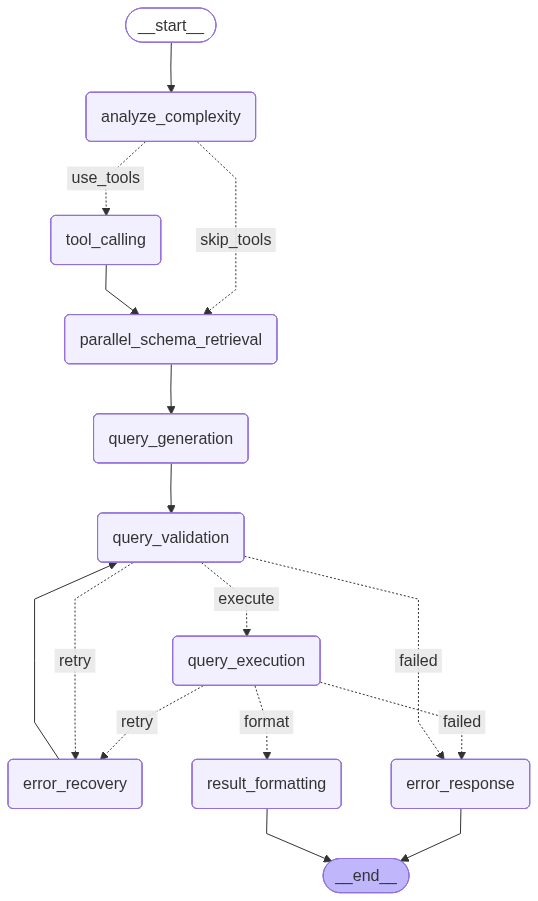


✅ Enhanced workflow now includes:
   • analyze_complexity node
   • tool_calling node (optional)
   • Conditional routing based on complexity


In [16]:
try:
    from IPython.display import Image, display
    display(Image(nl2sql_graph.get_graph().draw_mermaid_png()))
    print("\n✅ Enhanced workflow now includes:")
    print("   • analyze_complexity node")
    print("   • tool_calling node (optional)")
    print("   • Conditional routing based on complexity")
except Exception as e:
    print(f"Could not display graph visualization: {e}")
    print("\nEnhanced Graph structure:")
    print("  START → analyze_complexity → [simple/complex] → tool_calling/parallel_schema_retrieval")
    print("         → query_generation → query_validation → query_execution → result_formatting → END")


## Test Cases

Let's test the advanced NL2SQL pipeline with various queries.

In [17]:
def run_nl2sql_query(query: str, max_retries: int = 3, enable_tool_calling: str = "auto"):
    """
    Execute a natural language query against the database with full monitoring.
    
    Args:
        query: Natural language question about the database
        max_retries: Maximum number of retry attempts for error recovery (default: 3)
        enable_tool_calling: Tool calling mode (default: "auto")
            - "auto": Automatically decide based on query complexity
            - "always": Always use dynamic tool calling
            - "never": Never use dynamic tool calling (fastest)
    
    Returns:
        dict: Complete state including:
            - final_response: Natural language answer
            - generated_query: SQL query that was executed
            - relevant_tables: Tables used in the query
            - query_result: Raw SQL execution result
            - retry_count: Number of retries needed
            - execution_error: Any error encountered
            - tool_call_results: Results from dynamic tool calls (if used)
    
    Example:
        >>> # Auto mode (default)
        >>> result = run_nl2sql_query("How many customers do we have?")
        >>> 
        >>> # Force tool calling
        >>> result = run_nl2sql_query("Compare sales across regions", enable_tool_calling="always")
        >>>
        >>> # Disable tool calling for speed
        >>> result = run_nl2sql_query("List top 5 products", enable_tool_calling="never")
    """
    # Reset monitor for fresh metrics on each query
    monitor.reset()
    monitor.start_pipeline()
    
    # Initialize state with user query and retry configuration
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "user_query": query,
        "retry_count": 0,
        "max_retries": max_retries,
        # Tool calling configuration
        "use_tool_node": enable_tool_calling == "always"  # Override auto-detect
    }
    
    # If mode is "never", ensure tool calling is disabled
    if enable_tool_calling == "never":
        initial_state["use_tool_node"] = False
    # If mode is "auto", let analyze_complexity_node decide (don't set use_tool_node)
    elif enable_tool_calling == "auto":
        initial_state.pop("use_tool_node", None)  # Let node decide
    
    try:
        # Execute the LangGraph workflow
        result = nl2sql_graph.invoke(initial_state)
        success = result.get("final_response") is not None
        monitor.end_pipeline(success)
        
        # Print detailed monitoring summary
        monitor.print_summary()
        
        return result
    except Exception as e:
        monitor.end_pipeline(False)
        monitor.print_summary()
        raise

print("Helper function with monitoring and tool calling support defined!")
print("\nTool Calling Modes:")
print("  • 'auto'   : Automatically decide based on query complexity (default)")
print("  • 'always' : Always use dynamic tool calling")
print("  • 'never'  : Skip tool calling for maximum speed")


Helper function with monitoring and tool calling support defined!

Tool Calling Modes:
  • 'auto'   : Automatically decide based on query complexity (default)
  • 'always' : Always use dynamic tool calling
  • 'never'  : Skip tool calling for maximum speed


In [18]:
print("=" * 80)
print("Test 1: Simple query (auto mode - should skip tool calling)")
print("=" * 80)

result_1 = run_nl2sql_query("List the top 5 customers by order count", enable_tool_calling="auto")

print("\n" + "=" * 80)
print("FINAL RESPONSE:")
print("=" * 80)
print(result_1["final_response"])
print("\n")


INFO: Found 14 tables


Test 1: Simple query (auto mode - should skip tool calling)
🚀 Pipeline started at 16:16:02
📋 Simple query detected - using standard flow

🔍 Parallel Schema Retrieval: Starting vector search & database lookup...
🎯 [Vector] Using find_relevant_tables tool...
Searching schema vector store for question: List the top 5 customers by order count
🗄️  [Database] Using list_all_tables tool...
✅ [Database] Found 14 tables (schema: public)


c:\Users\sourabh.gupta\Documents\Workspace\Projects\nldbq-langchain\src\agents\vector_retriver_tools.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  return Chroma(
INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: Retrieved schema for: public.orders
INFO: Retrieved schema for: public.customers
INFO: Retrieved schema for: public.customer_customer_demo


Vector retrieve_schema results: [Document(metadata={'table_name': 'public.orders', 'type': 'table_schema', 'source': 'database_schema', 'database_name': 'northwind', 'db_type': 'postgres'}, page_content='Table: public.orders\n\n    Schema Details:\n    Table: public.orders\n\nColumns:\n  - order_id: SMALLINT NOT NULL\n  - customer_id: VARCHAR(5) NULL\n  - employee_id: SMALLINT NULL\n  - order_date: DATE NULL\n  - required_date: DATE NULL\n  - shipped_date: DATE NULL\n  - ship_via: SMALLINT NULL\n  - freight: REAL NULL\n  - ship_name: VARCHAR(40) NULL\n  - ship_address: VARCHAR(60) NULL\n  - ship_city: VARCHAR(15) NULL\n  - ship_region: VARCHAR(15) NULL\n  - ship_postal_code: VARCHAR(10) NULL\n  - ship_country: VARCHAR(15) NULL\n\nPrimary Key: order_id\n\nForeign Keys:\n  - customer_id -> customers(customer_id)\n  - employee_id -> employees(employee_id)\n  - ship_via -> shippers(shipper_id)\n\n    \n\nSample Data (first 3 rows):\n[(10248, \'VINET\', 5, datetime.date(1996, 7, 4), datetim

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


✅ Generated SQL:
SELECT customer_id 
FROM public.orders 
GROUP BY customer_id 
ORDER BY COUNT(*) DESC 
LIMIT 5;

🛡️ Query Validation: Checking query safety...


INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


✅ Query syntax validated in 2.345s


INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


✅ Validation Passed: Query is valid

⚡ Query Execution: Running SQL query...
✅ Query executed successfully in 0.027s
Result preview: [('SAVEA',), ('ERNSH',), ('QUICK',), ('HUNGO',), ('FOLKO',)]...

📝 Result Formatting: Creating natural language response...


INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


✅ Response generated
🏁 Completed in 47.40s (✅ Success)

📊 PRODUCTION MONITORING SUMMARY

⏱️  PIPELINE METRICS:
   Total Duration: 47.40s
   Status: ✅ Success
   Total Steps: 6
   Retries: 0
   Validation Failures: 0
   Execution Failures: 0

🔧 NODE EXECUTION METRICS:
   analyze_query_complexity: 1 exec, 0.000s total, 0.000s avg, 0 errors
   parallel_schema_retrieval: 1 exec, 2.623s total, 2.623s avg, 0 errors
   query_generation: 1 exec, 8.740s total, 8.740s avg, 0 errors
   query_validation: 1 exec, 27.099s total, 27.099s avg, 0 errors
   query_execution: 1 exec, 0.027s total, 0.027s avg, 0 errors
   result_formatting: 1 exec, 8.914s total, 8.914s avg, 0 errors

🤖 LLM USAGE METRICS:
   Total Calls: 0
   Token Usage: N/A (Ollama local model)

🔨 TOOL USAGE METRICS:
   get_table_schema: 3 calls, 100.0% success, 0.012s avg
   list_all_tables: 1 calls, 100.0% success, 0.013s avg
   find_relevant_tables: 1 calls, 100.0% success, 2.588s avg
   sql_db_query_checker: 1 calls, 100.0% success, 2